In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 

#ScikitLearn Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.svm import SVC 

#Qiskit imports
from qiskit import QuantumCircuit, Aer,QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.circuit import ParameterVector,Parameter
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.opflow import Gradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

SEED = 1430

Cleaning data

In [2]:
filename = "heart.csv"
df = pd.read_csv(filename)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df_1 = df[["age", "trestbps", "chol", "thalach", "oldpeak"]]
df_1.describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


In [4]:
infor = df.describe()

df2 = df[df.trestbps < infor.loc["mean", "trestbps"] + 3 * infor.loc["std", "trestbps"]]
df3 = df2[df.chol < infor.loc["mean", "chol"] + 3 * infor.loc["std", "chol"]]
df4 = df3[df.thalach > infor.loc["mean", "thalach"] - 3 * infor.loc["std", "thalach"]]
df_new = df4[df.oldpeak < infor.loc["mean", "oldpeak"] + 3 * infor.loc["std", "oldpeak"]]
df_new.head()

C:\Users\alber\AppData\Local\Temp/ipykernel_25380/2232066516.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[df.chol < infor.loc["mean", "chol"] + 3 * infor.loc["std", "chol"]]
C:\Users\alber\AppData\Local\Temp/ipykernel_25380/2232066516.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = df3[df.thalach > infor.loc["mean", "thalach"] - 3 * infor.loc["std", "thalach"]]
C:\Users\alber\AppData\Local\Temp/ipykernel_25380/2232066516.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_new = df4[df.oldpeak < infor.loc["mean", "oldpeak"] + 3 * infor.loc["std", "oldpeak"]]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df_new.cp = df_new.cp.map({0:"asymptomatic", 1: "typical angina", 2:"atypical angina", 3:"non-anginal pain"})
df_new.sex = df_new.sex.map({0:"Female", 1:"Male"}) 
df_new.exang = df_new.exang.map({0:"exercise did not induce angina", 1:"exercise induced angina"})
df_new.slope = df_new.slope.map({1:"upsloping", 2:"flat", 3:"downsloping"})
df_new.thal = df_new.thal.map({1:"normal",2:"fixed defect", 3:"reversable defect"})
df_new = pd.get_dummies(df_new, drop_first = True)
df_new.head(10)

C:\Users\alber\anaconda3\envs\workshop-qml\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,age,trestbps,chol,fbs,restecg,thalach,oldpeak,ca,target,sex_Male,cp_atypical angina,cp_non-anginal pain,cp_typical angina,exang_exercise induced angina,slope_upsloping,thal_normal,thal_reversable defect
0,63,145,233,1,0,150,2.3,0,1,1,0,1,0,0,0,1,0
1,37,130,250,0,1,187,3.5,0,1,1,1,0,0,0,0,0,0
2,41,130,204,0,0,172,1.4,0,1,0,0,0,1,0,0,0,0
3,56,120,236,0,1,178,0.8,0,1,1,0,0,1,0,0,0,0
4,57,120,354,0,1,163,0.6,0,1,0,0,0,0,1,0,0,0
5,57,140,192,0,1,148,0.4,0,1,1,0,0,0,0,1,1,0
6,56,140,294,0,0,153,1.3,0,1,0,0,0,1,0,1,0,0
7,44,120,263,0,1,173,0.0,0,1,1,0,0,1,0,0,0,1
8,52,172,199,1,1,162,0.5,0,1,1,1,0,0,0,0,0,1
9,57,150,168,0,1,174,1.6,0,1,1,1,0,0,0,0,0,0


In [6]:
df_reduced = df_new[["thal_reversable defect", "ca", "exang_exercise induced angina", "cp_atypical angina", "oldpeak", "slope_upsloping", "cp_typical angina", "target"]]
features=len(df_reduced.columns) - 1
df_reduced.head(10)

,thal_reversable defect,ca,exang_exercise induced angina,cp_atypical angina,oldpeak,slope_upsloping,cp_typical angina,target
0,0,0,0,0,2.3,0,0,1
1,0,0,0,1,3.5,0,0,1
2,0,0,0,0,1.4,0,1,1
3,0,0,0,0,0.8,0,1,1
4,0,0,1,0,0.6,0,0,1
5,0,0,0,0,0.4,1,0,1
6,0,0,0,0,1.3,1,1,1
7,1,0,0,0,0.0,0,1,1
8,1,0,0,1,0.5,0,0,1
9,0,0,0,1,1.6,0,0,1


In [7]:
df1 = df_reduced[df_reduced.target == 1].head(130)
df2 = df_reduced[df_reduced.target == 0].head(130)
df_reduced = pd.concat([df1, df2])

In [8]:
df_reduced.describe()

,thal_reversable defect,ca,exang_exercise induced angina,cp_atypical angina,oldpeak,slope_upsloping,cp_typical angina,target
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.407692,0.734615,0.361538,0.280769,1.065769,0.473077,0.142308,0.500000
std,0.492353,0.987740,0.481373,0.450242,1.099676,0.500238,0.350039,0.500964
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.500000
75%,1.000000,1.000000,1.000000,1.000000,1.800000,1.000000,0.000000,1.000000
max,1.000000,4.000000,1.000000,1.000000,4.400000,1.000000,1.000000,1.000000


In [9]:
X = df_reduced.drop("target", 1).values
y = df_reduced["target"].astype("int").values
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=10)

C:\Users\alber\AppData\Local\Temp/ipykernel_25380/3704920790.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_reduced.drop("target", 1).values


In [10]:
#Defining a quantum instance
simulator = Aer.get_backend('qasm_simulator')
shots = 8092
qinst = QuantumInstance(simulator, shots, SEED)

Using feature mapping and SVM

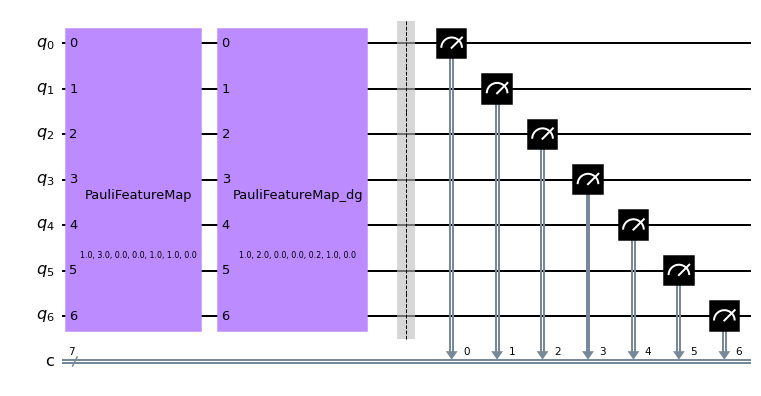

In [11]:
pauli_map = PauliFeatureMap(feature_dimension=features, reps=2, entanglement='linear')

#Building the kernel matrix
kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=qinst)

#Constructing the inner product circuit for given datapoints and feature map
circuit = kernel.construct_circuit(X_train[0], X_train[1])

circuit.decompose().draw('mpl')

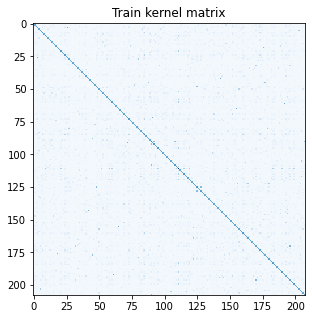

<Figure size 432x288 with 0 Axes>

In [12]:
train_matrix= kernel.evaluate(x_vec=X_train)

fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(train_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Train kernel matrix")
plt.show()
plt.savefig('kmatrix_fmap.png')

In [13]:
model = SVC(kernel= kernel.evaluate)

#Fiting the SVM model according to the given training data.
model.fit(X_train, y_train)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x00000183145AC970>>)

In [14]:
score = model.score(X_test, y_test)
print(f'Callable kernel classification test score: {score}')

Callable kernel classification test score: 0.6923076923076923


Using angle embbeding and SVM

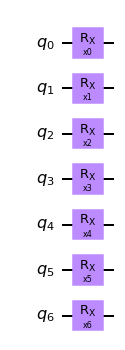

In [15]:
x_params = [Parameter(f'x{str(i)}') for i in range(features)]

def angle_embedding(nb_features):
       
    """
    Qubit - or rotation - encoding in RX gates.

    :param qc: The quantum circuit.
    :param nb_features: The number of features of the feature vector. 
    :return: The quantum circuit with the embedding layer. 
    """
    
    qc = QuantumCircuit(nb_features)

    for i in range(nb_features):
        qc.rx(x_params[i], i)
        
    return qc 
angle_map = angle_embedding(features)
angle_map.draw('mpl')

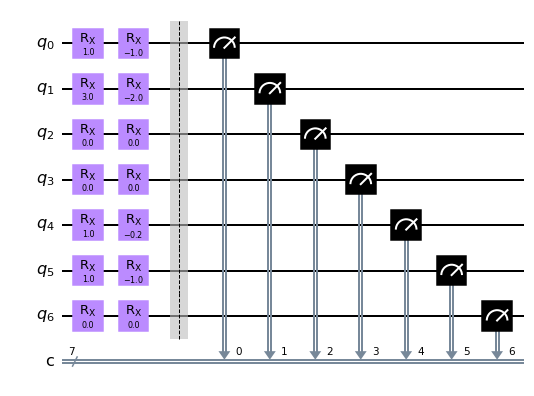

In [16]:
#Building the kernel matrix
kernel = QuantumKernel(feature_map=angle_map, quantum_instance=qinst)

#Constructing the inner product circuit for given datapoints and feature map
circuit = kernel.construct_circuit(X_train[0], X_train[1])

circuit.decompose().draw('mpl')

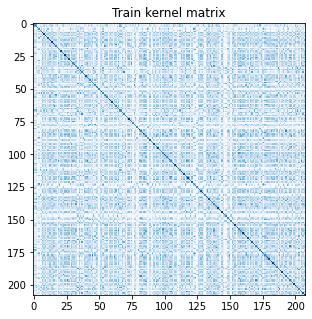

<Figure size 432x288 with 0 Axes>

In [17]:
train_matrix= kernel.evaluate(x_vec=X_train)

fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(train_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Train kernel matrix")
plt.show()
plt.savefig('kmatrix_angemb.png')

In [18]:
model = SVC(kernel= kernel.evaluate)

#Fiting the SVM model according to the given training data.
model.fit(X_train, y_train)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x00000183D101D7F0>>)

In [19]:
score = model.score(X_test, y_test)
print(f'Callable kernel classification test score: {score}')

Callable kernel classification test score: 0.8269230769230769


Using angle embbeding and QNN

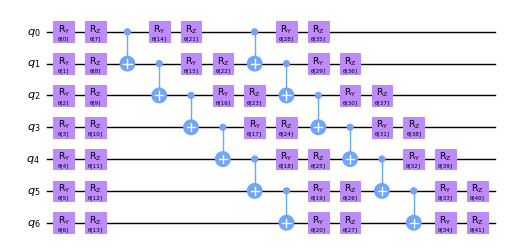

In [20]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(features, ['ry', 'rz'], 2, 'linear')
ansatz_tl.decompose().draw('mpl', scale=0.7)

In [21]:
var_circuit = angle_map.compose(ansatz_tl)

def one_qubit_binary(x):
    return x % 2

In [22]:
num_classes = 2
gradient = Gradient(grad_method="param_shift")
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=angle_map.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [23]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [24]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [25]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)



vqc = vqc.fit(X_train, y_train_1h)

3 - 181.78423611671133
6 - 180.42659611292873
9 - 177.5602409481557
12 - 176.41898621521028
15 - 175.16271407512144
18 - 174.45887934951068
21 - 173.34877518635284
24 - 173.2619504533255
27 - 173.28351945020572
30 - 172.97557413602263
33 - 172.2279431261748
36 - 169.8382940916999
39 - 167.04120354206088
42 - 166.99355350865454
45 - 166.87166338198833
48 - 165.73867314499972
51 - 165.299206261398
54 - 165.36563973955458
57 - 165.27288770873895
60 - 165.4921249012972
63 - 164.09608003271137
66 - 163.51043008383243
69 - 163.5948925342092
72 - 163.5374923784466
75 - 163.63522470755555
78 - 163.64027692257883
81 - 163.37455893392456
84 - 163.33413305525147
87 - 162.97351634689772
90 - 162.85397213835938
93 - 162.73802000832347
96 - 162.56405587701596
99 - 161.75623915484223
102 - 161.93794604881055
105 - 161.68162365942914
108 - 161.67867748351057
111 - 161.6447737868012
114 - 161.42505971677417
117 - 161.39063812247696
120 - 161.07413891262615
123 - 161.13478840172985
126 - 161.14324509839

In [26]:
score_train = vqc.score(X_train, y_train_1h)
score_test = vqc.score(X_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.7259615384615384
Score on the test set 0.75


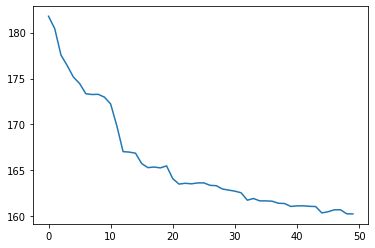

In [27]:
plt.plot(loss_recorder)
plt.savefig('Loss_QNN.png')

Running in a QPU using angle embbeding and SVM

In [28]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education',group='qscitech-quantum',project='qc-bc-workshop')
ibmq_jakarta = provider.get_backend('ibmq_jakarta')

In [29]:
qinst = QuantumInstance(ibmq_jakarta,shots=8192)

In [30]:
#Building the kernel matrix
kernel = QuantumKernel(feature_map=angle_map, quantum_instance=qinst)

In [31]:
model = SVC(kernel= kernel.evaluate)

#Fiting the SVM model according to the given training data.
model.fit(X_train, y_train)

C:\Users\alber\anaconda3\envs\workshop-qml\lib\site-packages\qiskit\utils\run_circuits.py:727: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)


SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x00000183D302F370>>)

In [ ]:
score = model.score(X_test, y_test)
print(f'Callable kernel classification test score: {score}')

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))